In [146]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf 
import matplotlib.pyplot as plt
from parsing import *
from os import listdir
from os.path import isfile, join
import os


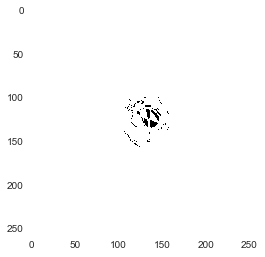

In [141]:

# mask = process_contour_file('SC-HF-I-4')
# display_boolean_mask(mask)

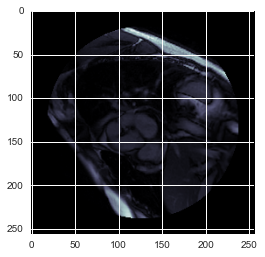

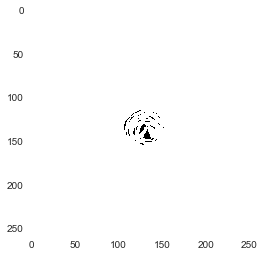

In [371]:
import dicom 
import pylab
# https://rstudio-pubs-static.s3.amazonaws.com/192658_285f8bf10f8345d2857055fe2b736cb1.html
def visualize_dicom(dcm_file, save_file = None):
    dcm_path = DICOM_DIR + dcm_file
    ds=dicom.read_file(dcm_path)
    pylab.imshow(ds.pixel_array, cmap=pylab.cm.bone)
    if save_file is not None:
        pylab.savefig(save_file)
    pylab.show()

# http://stackoverflow.com/questions/9638826/plot-a-black-and-white-binary-map-in-matplotlib
def display_boolean_mask(mask, save_file = None):
    plt.imshow(mask)
    plt.imshow(mask, cmap='Greys', interpolation = 'none')
    if save_file is not None:
        plt.savefig(save_file)
    plt.show()

visualize_dicom('SCD0000101/1.dcm', 'SCD0000101-1.jpg')
mask = process_contour_file('SC-HF-I-1')
display_boolean_mask(mask, 'SC-HF-I-1.jpg')
# pixel_data_dict = process_dicom_file('SCD0000101')

In [285]:
import logging
DATA_DIR = 'final_data/'
DICOM_DIR = DATA_DIR + 'dicoms/'
CONTOUR_DIR = DATA_DIR + 'contourfiles/'
LINK_FILE = DATA_DIR + 'link.csv'

def process_link_file(fileName):
    f = open(fileName, 'rb')
    header = f.readline()
    links = {}
    for line in f:
        patient_id, original_id =  line.strip('\n').split(',')
        links[patient_id] = original_id
    return links

def process_contour_file(filename, flag = 'inner', width = 256, height =256):
    CONTOUR_TYPE = 'i-contours' if (flag == 'inner') else 'o-contours'
    if '/' not in filename:
        filepath = CONTOUR_DIR + filename + "/" + CONTOUR_TYPE + "/"
    else:
        filepath = filename
    contour_file_list = [f for f in listdir(filepath) if isfile(join(filepath, f))]

    coords_list = []
    for contour_file in contour_file_list:
        contour_filepath = filepath + contour_file
        coords_list.extend(parse_contour_file(contour_filepath))
    
    boolean_mask = poly_to_mask(coords_list, width, height)
    return boolean_mask


def process_dicom_file(filename):
    if '/' not in filename:
        filepath = DICOM_DIR + filename + "/"
    else:
        filepath = filename
        
    dicom_file_list = [f for f in listdir(filepath) if isfile(join(filepath, f))]
    dicom_image_data = []
    for dicom_file in dicom_file_list:
        dicom_filepath  = filepath + dicom_file
#       index, extension = dicom_file.split('.')
#       index = int(index)
        image_data = parse_dicom_file(dicom_filepath)
        dicom_image_data.append(image_data['pixel_data'])
    return np.array(dicom_image_data)  # 3 dimensional dicom data np array [image_no, pixel_width, pixel_height]

#http://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

def process_dicoms(dicom_dir = DICOM_DIR):
    dicom_filenames = get_immediate_subdirectories(dicom_dir)
    # dicom_filenames = [d for d in listdir(dicom_dir) if isfile(join(dicom_dir, d))]
    dicom_data = {}
    for dicom_file in dicom_filenames:
        pixel_data = process_dicom_file(dicom_file)
        dicom_data[dicom_file] = pixel_data
    return dicom_data

def process_contours(contour_dir = CONTOUR_DIR, flag = 'inner'):
    CONTOUR_TYPE = 'icontour' if flag == 'inner' else 'ocontour'
    contour_filenames = get_immediate_subdirectories(contour_dir)
    contour_data = {}
    for contour_file in contour_filenames:
        mask_data = process_contour_file(contour_file)
        contour_data[contour_file] = mask_data
    return contour_data
# link dicoms to contours 

def link_dicoms_and_contours(dicom_data, contour_data, link_map):
    contour_matrix = np.array([])
    dicom_matrix = np.array([])
    
    for dicom_id in dicom_data:
        if dicom_id not in link_map:
            print "dicom file id %d does not have an entry in linkage map - skipping " % (dicom_id)
            continue
        contour_id = link_map[dicom_id]
        if contour_id not in contour_data:
            print "dicom_id: %d does not have a matching contour image data for id: %d" % (dicom_id, contour_id)
            continue
            
        patient_dicom_data = dicom_data[dicom_id].astype(int)
        num_dicom_images = len(patient_dicom_data)
        expanded_contours = np.expand_dims(contour_data[contour_id].astype(int), axis = 0)
        repeated_contours = np.repeat(expanded_contours, repeats = num_dicom_images, axis = 0) 
        
        contour_matrix = np.vstack([contour_matrix, repeated_contours]) if contour_matrix.size else repeated_contours
        dicom_matrix = np.vstack([dicom_matrix, patient_dicom_data]) if dicom_matrix.size else patient_dicom_data
        
    return (contour_matrix, dicom_matrix)
    
def create_data_pipeline(dicom_dir = DICOM_DIR, contour_dir = CONTOUR_DIR, link_file = LINK_FILE, flag = 'inner'):
    dicom_data = process_dicoms(dicom_dir)
    contour_data = process_contours(contour_dir)

    links = process_link_file(link_file)
    
    contour_matrix, dicom_matrix = link_dicoms_and_contours(dicom_data, contour_data, links)
    
    # match individual dicom images each with the same contour
    return contour_matrix, dicom_matrix

data = create_data_pipeline()

In [287]:
def get_minibatches(data, minibatch_size, shuffle=True):
    """
    Iterates through the provided data one minibatch at at time. You can use this function to
    iterate through data in minibatches as follows:

        for inputs_minibatch in get_minibatches(inputs, minibatch_size):
            ...

    Or with multiple data sources:

        for inputs_minibatch, labels_minibatch in get_minibatches([inputs, labels], minibatch_size):
            ...

    Args:
        data: there are two possible values:
            - a list or numpy array
            - a list where each element is either a list or numpy array
        minibatch_size: the maximum number of items in a minibatch
        shuffle: whether to randomize the order of returned data
    Returns:
        minibatches: the return value depends on data:
            - If data is a list/array it yields the next minibatch of data.
            - If data a list of lists/arrays it returns the next minibatch of each element in the
              list. This can be used to iterate through multiple data sources
              (e.g., features and labels) at the same time.

    """
    
    num_samples = len(data[0])
    if(shuffle):
        indices = np.random.permutation(num_samples) 
    else:
        indices = np.arange(num_samples)

    minibatches = []
    for minibatch_start in np.arange(0, num_samples, minibatch_size):
        minibatch_end = min(num_samples, minibatch_start + minibatch_size)
        minibatch_indices = indices[minibatch_start:minibatch_end]

        dicom_images = data[0][minibatch_indices]
        boolean_targets = data[1][minibatch_indices]
        
        minibatch = [dicom_images, boolean_targets]
        minibatches.append(minibatch)

    return minibatches

In [347]:
# Conv-net architecture based off of
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py
# 
import tensorflow as tf
class ConvNet:
    def __init__(self, output_width, output_height, dropout = 0.0, namespace = "convnet"):
        # Store layers weight & bias
        with tf.variable_scope("cnn", reuse = None):
            xavier_init = tf.contrib.layers.xavier_initializer()
            self.output_width = output_width
            self.output_height = output_height
            self.output_size = output_width * output_height
            
            self.weights = {
            'wc1': tf.get_variable(name='wc1',dtype = tf.float32, shape = [5,5,1,4], initializer = xavier_init),
            'wc2': tf.get_variable(name='wc2',dtype = tf.float32, shape = [5,5,4,8], initializer = xavier_init),
            'wd1': tf.get_variable(name='wd1',dtype = tf.float32, shape = [64*64*8,1024], initializer = xavier_init),
            'out': tf.get_variable(name='wout',dtype = tf.float32, shape = [1024, self.output_size], \
                                    initializer = xavier_init)
            }

            self.biases = {
            'bc1': tf.get_variable(name='bc1', dtype = tf.float32, shape = [4], initializer = tf.constant_initializer(0)),
            'bc2': tf.get_variable(name='bc2', dtype = tf.float32, shape = [8], initializer = tf.constant_initializer(0)),
            'bd1': tf.get_variable(name='bd1', dtype = tf.float32, shape = [1024], initializer = tf.constant_initializer(0)),
            'out': tf.get_variable(name='bout', dtype = tf.float32, shape = [self.output_size], \
                                    initializer = tf.constant_initializer(0))
            }
    
    def conv2d(self, x, W, b, strides=1):
        # Conv2D wrapper, with bias and relu activation
        x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
        x = tf.nn.bias_add(x, b)
        return tf.nn.relu(x)


    def maxpool2d(self, x, k=2):
        # MaxPool2D wrapper
        return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                              padding='SAME')

    def forwardProp(self,X, dropout = 0.0):
        # Reshape input picture
        tf.expand_dims(X, -1) # x goes from [batch_size, width, height] -> [batch, width, height, 1] i.e. depth = 1
        # Convolution Layer
        weights = self.weights
        biases = self.biases
        
        print "got here just ifne"
        conv1 = self.conv2d(X, weights['wc1'], biases['bc1'])
        # OPTIONAL: Max Pooling (down-sampling) -- unused here
        conv1 = self.maxpool2d(conv1, k=2)

        # Convolution Layer
        conv2 = self.conv2d(conv1, weights['wc2'], biases['bc2'])
        # OPTIONAL: Max Pooling (down-sampling) -- unused here
        conv2 = self.maxpool2d(conv2, k=2)

        # Fully connected layer
        # Reshape conv2 output to fit fully connected layer input
        fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
        fc1 = tf.nn.relu(fc1)
        # Apply Dropout
        #fc1 = tf.nn.dropout(fc1, dropout)

        # Output, class prediction
        out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
        
        out = tf.reshape(out, [-1, self.output_width, self.output_height])
        return out

class Config:
    '''Holds model hyperparameters and data information.'''
    contour_width = 256 # size of the boolean mask 
    contour_height = 256
    image_width = 256 # size of dicom image 
    image_height = 256
    output_size = 256 * 256
    filter_size = 5
    batch_size = 8
    epochs = 10
    max_gradient_norm = 5 
    optimizer = 'adam'
    learning_rate = 1e-4
    clip_gradients = False
    dropout = 0.0

    def __init__(self):
        pass   

def get_optimizer(opt):
    if opt == "adam":
        optfn = tf.train.AdamOptimizer
    elif opt == "sgd":
        optfn = tf.train.GradientDescentOptimizer
    else:
        assert (False)
    return optfn

class ImageSegmentation(object):
    def __init__(self, config, model, *args):
        self.config = config
        self.model = model
        # set up placeholder tokens
        self.add_placeholders()
        
        with tf.variable_scope("image-seg", initializer=tf.uniform_unit_scaling_initializer(1.0)):

            self.preds = self.setup_system()           
            self.loss = self.setup_loss(self.preds)
            self.train_op = self.setup_training_op(self.loss)
        
    def add_placeholders(self):
        self.input_placeholder = tf.placeholder(tf.int32, shape= \
                                    (None, self.config.image_width, self.config.image_height), name="dicom")
        self.labels_placeholder = tf.placeholder(tf.int32, shape = \
                                    (None, self.config.contour_width, self.config.contour_height), name = 'target')

    def setup_system(self):
        X = self.input_placeholder
        model = self.model

        pred_mask = model.forwardProp(X)
        return pred_mask

    def setup_loss(self, preds):
        target = self.labels_placeholder
        
        target = tf.reshape(target, (-1, self.config.width * self.config.height))
        preds = tf.reshape(preds, (-1, self.config.width * self.config.height))
        
        pixel_loss = tf.nn.softmax_cross_entropy_with_logits(logits = preds, labels = target)
        loss = tf.reduce_sum(pixel_loss)
        return loss

    def setup_training_op(self, loss, op_type = "adam"):
        method = get_optimizer(op_type)

        optimizer = method(learning_rate=self.config.learning_rate)

        ## Optional: Clip large gradient values #########

        gradients_and_variables = optimizer.compute_gradients(loss)
        gradients = [item[0] for item in gradients_and_variables]
        variables = [item[1] for item in gradients_and_variables]                      
        # if self.config.clip_gradients:
        #     gradients , _ = tf.clip_by_global_norm(gradients, self.config.max_grad_norm)
        #     gradients_and_variables = zip(gradients, variables)        
        self.grad_norm = tf.global_norm(gradients)           
#        train_op = optimizer.apply_gradients(gradients_and_variables)

        train_op = optimizer.minimize(loss)
        return train_op
    
    def optimize(self, images, targets):
        """
        Takes in actual data to optimize model
        This method is equivalent to a step() function
        """

        # images are unrolled into 1D -> convert back into 2D
        batch_size = len(images)
        
        np.reshape(images, self.config.image_width, self.config.image_height)
        np.reshape(targets, self.config.contour_width, self.config.contour_height)
        
        input_feed = {}

        input_feed[self.input_placeholder] = images
        input_feed[self.labels_placeholder] = targets
        input_feed[self.dropout_placeholder] = self.config.dropout
        output_feed = [self.loss]

        loss= session.run(output_feed, feed_dict=input_feed)
        loss = np.sum(loss)      

        return loss            

    def run_epoch(self, sess, train, train_dir, epoch, sample = 100, log = True):
        batch_losses = []
        minibatches = get_minibatches(train, self.config.batch_size)
        savePath = train_dir + '/model'

        for i, batch in enumerate(minibatches):
            input_batch, target_batch = batch

            loss = self.optimize(sess, input_batch, target_batch)
            batch_losses.append(loss)       
            #this normalizes the loss over number of training examples in minibatch
            loss = loss * self.config.batch_size/ input_batch.shape[0] 


            evalstep = 10
            if (i % evalstep == 0 and i > 0):
                print("\nCurrently on minibatch: ", i)
                if (i % 100 == 0 and i > 0):
                    print("Saver checkpoint on this minibatch...: ", i)
                    self.saver.save(sess, savePath, global_step = i + epoch)

        return sum(batch_losses) 


    def train(self, session, dataset, train_dir, sample=100, log=True):
        """
        :param session: it should be passed in from train.py
        :param dataset: a representation of the data
        :param train_dir: path to the directory where you should save the model checkpoint
        :return:
        """
        tic = time.time()
        params = tf.trainable_variables()
        num_params = sum(map(lambda t: np.prod(tf.shape(t.value()).eval()), params))
        toc = time.time()

        logging.info("Number of params: %d (retreival took %f secs)" % (num_params, toc - tic))
        logging.info(vars(self.config))
        savePath = train_dir + "/model"
        epoch_losses = []
        for epoch in range(self.config.epochs):
            print("\nRunning epoch ", epoch + 1)
            loss = self.run_epoch(session, dataset, paragraph, train_dir, epoch + 1)
            
            print("\nFinished running epoch ", epoch + 1)
            epoch_losses.append(loss)
            self.saver.save(session, savePath, global_step = epoch + 1)
        
            logging.info("Epoch: {} end, train loss: {}".format(epoch, loss))

In [361]:
tf.reset_default_graph()
cnn = ConvNet(256,256)
model = ImageSegmentation(config, cnn)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    config = Config() 
    train_loss = ir.train(sess, data, 'train_dir', 2)
    
    print "train loss is %f" % train_loss
    

got here just ifne


TypeError: DataType int32 for attr 'T' not in list of allowed values: float16, float32, float64

In [353]:
config = Config()



train = data[0][:8]
train = np.expand_dims(train, -1)
print train.shape
preds = model.forwardProp(train.astype('f'))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    lol = sess.run(preds)
print lol

(8, 256, 256, 1)
got here just ifne
[[[ -7.62400450e-05   5.11140004e-03  -9.19638295e-03 ...,   1.39062805e-03
     5.16066002e-03  -4.15401766e-03]
  [  8.64765048e-03   1.50727935e-03  -2.48573581e-03 ...,   1.38369352e-02
    -1.23870168e-02  -9.34964628e-04]
  [ -9.12402989e-04   4.51627839e-03  -7.23642157e-03 ...,   2.01308262e-03
     4.16669808e-03   6.11998234e-03]
  ..., 
  [ -6.68686698e-04  -5.75802522e-04  -2.99459673e-03 ...,  -1.23156863e-03
     4.79114614e-03   8.76441225e-03]
  [ -6.79306453e-03  -4.58280882e-03   4.40423097e-03 ...,  -1.48207927e-03
    -1.80512469e-03   7.23037077e-03]
  [  6.45090640e-03  -1.61416770e-03  -1.96026085e-04 ...,  -1.03398524e-02
    -1.91760226e-03  -4.18553501e-03]]

 [[ -7.62400450e-05   5.11140004e-03  -9.19638295e-03 ...,   1.39062805e-03
     5.16066002e-03  -4.15401766e-03]
  [  8.64765048e-03   1.50727935e-03  -2.48573581e-03 ...,   1.38369352e-02
    -1.23870168e-02  -9.34964628e-04]
  [ -9.12402989e-04   4.51627839e-03  -7.2